In [1]:
# ising_from_scratch.py
# 2D Ising Model implemented from scratch for single-site Metropolis sampling
# - Target: pi(s) = exp(-beta * H(s)) / Z
# - H(s) = -J * sum_{<nn>} s_i s_j
# - Cold start: all spins +1
# - Single-site proposals: pick random site, flip proposal, alpha = min(1, pi(y)/pi(x))
# - Periodic boundary conditions
# - Avoids NumPy high-level builtins: only uses NumPy for array creation & indexing
#
# Requirements: numpy, matplotlib
# Run: python ising_from_scratch.py

import numpy as np
import random
import math
import matplotlib.pyplot as plt

# ----------------------------
# Basic helpers (from scratch)
# ----------------------------
def init_cold_lattice(L):
    """Cold start: all spins +1 as a numpy array (int)."""
    return np.ones((L, L), dtype=int)

def periodic(i, L):
    """Periodic boundary: wrap index using Python modulo."""
    return i % L

def local_neighbor_sum(lattice, i, j):
    """Compute sum of four nearest neighbors (explicit indexing)."""
    L = lattice.shape[0]
    s_up = lattice[periodic(i-1, L), j]
    s_down = lattice[periodic(i+1, L), j]
    s_left = lattice[i, periodic(j-1, L)]
    s_right = lattice[i, periodic(j+1, L)]
    return s_up + s_down + s_left + s_right

def delta_H(lattice, i, j, J=1.0):
    """
    H = -J * sum_{<nn>} s_i s_j
    For flipping spin s -> -s at (i,j): ΔH = 2 * J * s * sum(neighbors)
    """
    s = lattice[i, j]
    neigh_sum = local_neighbor_sum(lattice, i, j)
    return 2.0 * J * s * neigh_sum

def total_H(lattice, J=1.0):
    """Compute total H = -J * sum_{<ij>} s_i s_j
    Count each pair once by summing s(i,j)*s(i,j+1) and s(i,j)*s(i+1,j).
    Implemented with explicit loops.
    """
    L = lattice.shape[0]
    H = 0.0
    for i in range(L):
        for j in range(L):
            s = lattice[i, j]
            s_right = lattice[i, periodic(j+1, L)]
            s_down = lattice[periodic(i+1, L), j]
            H += -J * (s * s_right + s * s_down)
    return H

def magnetization(lattice):
    """Magnetization per site: average spin, computed with loops."""
    L = lattice.shape[0]
    total = 0
    for i in range(L):
        for j in range(L):
            total += lattice[i, j]
    return total / (L * L)


In [6]:
# ----------------------------
# Metropolis step (single-site proposals)
# ----------------------------
def metropolis_step_single(lattice, beta, J=1.0):
    """
    Perform L*L single-site proposals (one MCS).
    For each proposal:
      - pick a site uniformly at random
      - compute ΔH for flipping
      - acceptance alpha = min(1, exp(-beta * ΔH))
      - flip with probability alpha
    Returns number of accepted flips during this MCS.
    """
    L = lattice.shape[0]
    attempts = L * L
    accepted = 0
    for _ in range(attempts):
        i = random.randrange(0, L)
        j = random.randrange(0, L)
        dH = delta_H(lattice, i, j, J)
        if dH <= 0:
            # flipping reduces H -> pi increases -> accept deterministically
            lattice[i, j] = -lattice[i, j]
            accepted += 1
        else:
            prob = math.exp(-beta * dH)
            if random.random() < prob:
                lattice[i, j] = -lattice[i, j]
                accepted += 1
    return accepted

# ----------------------------
# Runner & plotting
# ----------------------------
#def run_ising_from_scratch(L=32, beta=0.5, J=1.0, n_steps=1000, measure_interval=1, seed=None, verbose=False):
def run_ising_from_scratch(L, beta, J, n_steps, measure_interval, seed, verbose):
        
    """
    Run the Ising model with cold start:
      L : lattice size
      beta : inverse temperature
      J : coupling
      n_steps : Monte Carlo steps (MCS)
      measure_interval : how many steps between records
      seed : RNG seed for reproducibility
    Returns: history dict and final lattice
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    lattice = init_cold_lattice(L)
    steps = []
    energies = []
    mags = []
    accepts = []
    for step in range(1, n_steps + 1):
        accepted = metropolis_step_single(lattice, beta, J)
        if step % measure_interval == 0:
            H = total_H(lattice, J)
            M = magnetization(lattice)
            steps.append(step)
            energies.append(H / (L * L))    # energy per site
            mags.append(M)                  # magnetization per site
            accepts.append(accepted / (L * L))
        if verbose and (step % (n_steps // 5 if n_steps >= 5 else 1) == 0):
            print(f"Step {step}/{n_steps}: E={energies[-1]:.4f}, M={mags[-1]:.4f}, acc={accepts[-1]:.3f}")
    history = {'step': steps, 'energy': energies, 'magnetization': mags, 'acceptance': accepts}
    return history, lattice

def plot_time_series(history, title_prefix=""):
    plt.figure(figsize=(8,4))
    plt.plot(history['step'], history['energy'], linewidth=1)
    plt.xlabel('Monte Carlo steps')
    plt.ylabel('Energy per site')
    plt.title(title_prefix + 'Energy per site vs steps')
    plt.grid(alpha=0.3)
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(history['step'], history['magnetization'], linewidth=1)
    plt.xlabel('Monte Carlo steps')
    plt.ylabel('Magnetization per site')
    plt.title(title_prefix + 'Magnetization per site vs steps')
    plt.grid(alpha=0.3)
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(history['step'], history['acceptance'], linewidth=1)
    plt.xlabel('Monte Carlo steps')
    plt.ylabel('Acceptance fraction (per MCS)')
    plt.title(title_prefix + 'Acceptance fraction vs steps')
    plt.grid(alpha=0.3)
    plt.show()

def plot_lattice(lattice, title="Final spin configuration"):
    plt.figure(figsize=(6,6))
    L = lattice.shape[0]
    # map +1 -> 0 and -1 -> 1 so we see domains (no numpy convenience used)
    img = [[0 if lattice[i,j] == 1 else 1 for j in range(L)] for i in range(L)]
    plt.imshow(img, interpolation='nearest')
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.show()

Step 80/400: E=-1.6997, M=0.8932, acc=0.102
Step 160/400: E=-1.8021, M=0.9366, acc=0.058
Step 240/400: E=-1.7101, M=0.9002, acc=0.087
Step 320/400: E=-1.7066, M=0.8941, acc=0.102
Step 400/400: E=-1.7292, M=0.9036, acc=0.089


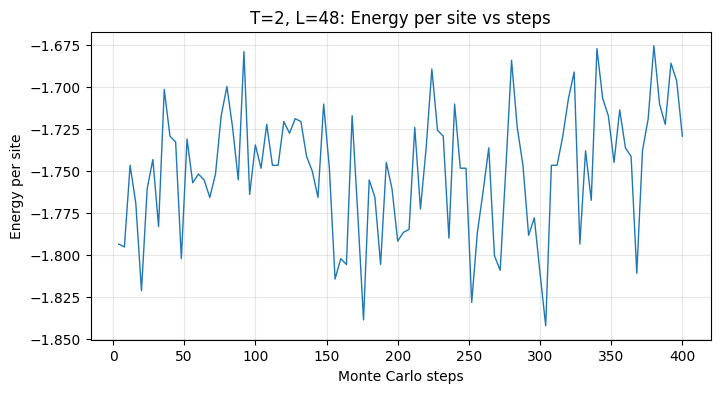

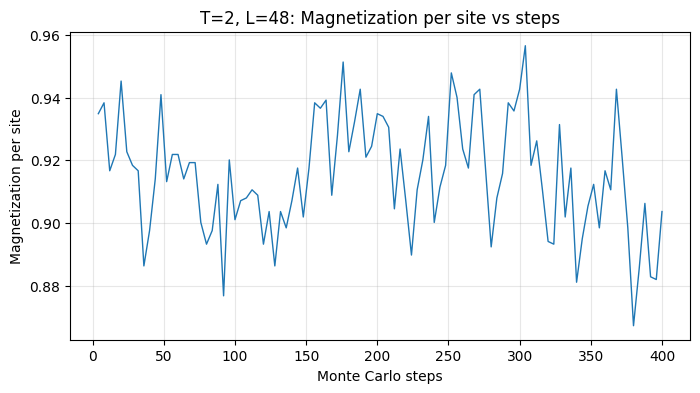

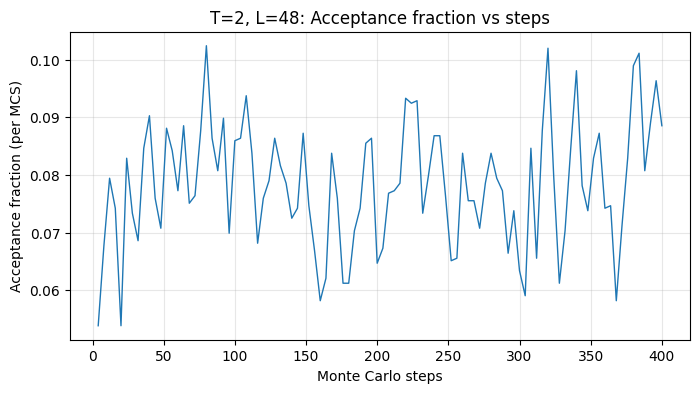

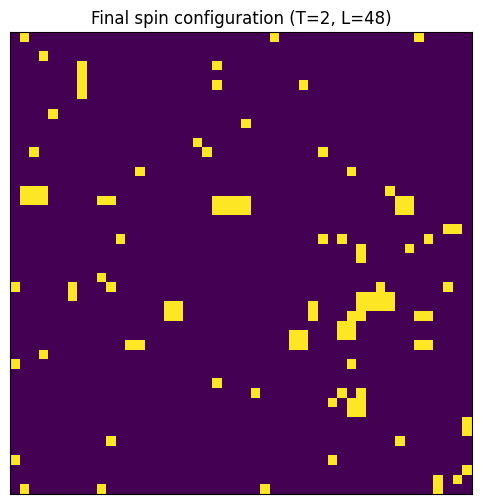

Summary:
L=48, T=2, beta=0.5000, steps=400
Final energy per site = -1.7292
Final magnetization per site = 0.9036


In [10]:
# ----------------------------
# RUN PARAMETERS (edit)
# ----------------------------
if __name__ == "__main__":
    L = 48                 # lattice linear size
    T = 2             # temperature (constant)
    beta = 1.0 / T         # inverse temperature (k_B = 1)
    J = 1.0
    n_steps = 400          # Monte Carlo steps (each MCS = L*L proposals)
    measure_interval = 4   # record observables every this many steps
    seed = 12345
    verbose = True

    history, final_lattice = run_ising_from_scratch(L=L, beta=beta, J=J,
                                                   n_steps=n_steps, measure_interval=measure_interval,
                                                   seed=seed, verbose=verbose)

    plot_time_series(history, title_prefix=f"T={T}, L={L}: ")
    plot_lattice(final_lattice, title=f"Final spin configuration (T={T}, L={L})")

    print("Summary:")
    print(f"L={L}, T={T}, beta={beta:.4f}, steps={n_steps}")
    print(f"Final energy per site = {history['energy'][-1]:.4f}")
    print(f"Final magnetization per site = {history['magnetization'][-1]:.4f}")
